# Machine Learning in the Real World

##                1.Data preparation and cleaning

## Import Python Libraries

In [7]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.cm
import pathlib
import csv
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
from sklearn.model_selection import train_test_split

# for map graphical view:
import matplotlib.cm
import matplotlib as mpl
from geonamescache import GeonamesCache
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap

# for PCA:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for images comparison:
import cv2
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image

# model for feature selection:
from sklearn import datasets, linear_model, decomposition
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline
import sklearn.preprocessing as sp
import sklearn.feature_selection as fs
from sklearn import kernel_ridge
#import skfeature as skf

# Import the random forest model.
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.grid_search import GridSearchCV

# Imports for kernel ridge:
#from sklearn.model_selection import GridSearchCV


# loading bar
from ipywidgets import FloatProgress
from IPython.display import display

## Defining Data Paths And Variables

In [8]:
# Data paths
path_train = 'working_data/train_data.csv'
path_test = 'working_data/test_data.csv'
path_complete_data = 'merged_data_ready/merged_data.csv'
paths = []
#paths.append('raw_data\DB_Data\Jobs.csv')
#paths.append('raw_data\DB_Data\Global_Financial_Development_Data_2.csv')
paths.append('raw_data\DB_Data\Edstast_data.csv')
paths_fixed = []
#paths_fixed.append('raw_data\DB_Data\Job_fixed.csv')
#paths_fixed.append('raw_data\DB_Data\Global_Financial_Development_Data_2_fixed.csv')
paths_fixed.append('raw_data\DB_Data\Edstast_data_fixed.csv')
input_labels = 'raw_data\Labels\Happy_Planet_Index_Data'


# Paths for the graphical map visualization use
countries_codes = 'raw_data/DB_Data/WDI_Country.csv'
shapefile = 'map_files/ne_10m_admin_0_countries'
template_image = 'map_files/imgfile.png'
globe_plots = 'globe_plots/'
uncorrolated_plots = 'uncorrolated_images/'

# Years with labels
rellevant_years_for_labels = ['1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999',\
                              '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2009', '2012', '2016']
rellevant_years = [year + '.00' for year in rellevant_years_for_labels]

## Obtaining the Data Set

In [21]:
# Merge the data with the labels
def mergeDataWithLabels(working_frame, labels):
    result = pd.merge(working_frame, labels, how='inner', on=['country', 'year'])
    result.to_csv(path_complete_data)

# Cleaning the CSV Files Out From Commas
def cleanCommasFromCSV(path_old, path_new):
    with open(path_old, "r", newline="") as infile, open(path_new, "w", newline="") as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        for row in reader:
            writer.writerow(item.replace(",", "") for item in row)

# Obtain The Labeled Data
def getDataFrameForLabelCSV(path, year):
    df = pd.read_csv(path, skiprows=0, usecols=[1, 8])
    df.loc[:, 'year'] = pd.Series(float(rellevant_years[rellevant_years_for_labels.index(year)]), index=df.index)
    cols = df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df = df[cols]
    df.drop(df.index[[0]])
    return df

# Take Data From DataSets
def extractDataFromCSV(paths, path_downloaded):
    df = pd.read_csv(paths[0],header=None,skiprows=0, encoding='iso-8859-1')
    df.drop(df.columns[[1,3]], axis=1, inplace=True)
    df.loc[0,0] = 'country'
    df.columns = df.loc[0]
    df = pd.pivot_table(df,index ='country', columns='Indicator Name')
    df = df.stack(level=0)
    df.reset_index(inplace=True)
    df.rename(columns={0: 'year'}, inplace=True)
    df.rename(columns={"Indicator Name": 'series'},inplace=True)
    df.to_csv(path_complete_data, encoding='iso-8859-1')
    df = pd.read_csv(path_complete_data, encoding='iso-8859-1')
    df.drop(df.columns[[0]], axis=1, inplace=True)
    return df

# The Main Data Extract Function
def obtainDataFromLocalDBs():
    f = FloatProgress(min=0, max=100)
    display(f)

    # extract the labels dataframe from the csv files
    lis = []
    for year in rellevant_years_for_labels:
        path = input_labels + '_' + year + '.csv'
        path = pathlib.Path(path)
        df = getDataFrameForLabelCSV(path, year)
        lis.append(df)
    labels_df = pd.concat(lis)
    f.value += 10
    # extract all the data dataframe from the csv files
    for i in range(len(paths)):
        cleanCommasFromCSV(paths[i], paths_fixed[i])
    f.value += 20
    df = extractDataFromCSV(paths_fixed, path_complete_data)
    f.value += 20

    # merge (by inner join) the data with the labels
    mergeDataWithLabels(df, labels_df)
    f.value += 50

# Run to Extract Data (invokes all the other functions above)
obtainDataFromLocalDBs()

## Graphical representation on globus map

### For viewing map graphics, you should install 2 libraries:

#### 1. Install Basemap:
        · To install this package with conda run, type:
          conda install -c conda-forge basemap=1.0.8.dev0
        · download package and install from: http://matplotlib.org/basemap/
#### 2. Install GeonamesCache:
        · To install this package with conda run, type:
          conda install -c mbonix geonamescache=0.20
          pip install geonamescache
        · download package and install from: https://pypi.python.org/pypi/geonamescache
          look for version 0.20

In [9]:
def plotDataOnMap(data, year = 'mean', feature = "Happy Planet Index", binary=False, descripton=''): 
    if binary:
        num_colors = 2
    else:
        num_colors = 9
    cols = ['country', feature]
    splitted = feature.split()
    title = feature + ' rate per country'
    imgfile = globe_plots + feature + '_'+ year + '.png'
    if descripton == '':
        descripton = '''
        Expected values of the {} rate of countriers. Countries without data are shown in grey.
        Data: World Bank - worldbank.org • Lables: HappyPlanetIndex - happyplanetindex.org'''.format(feature)

    gc = GeonamesCache()
    iso3_codes = list(gc.get_dataset_by_key(gc.get_countries(), 'iso3').keys())
    df = pd.read_csv(countries_codes, skiprows=0, usecols=[0, 1], encoding='iso-8859-1')
    data_map = pd.merge(df, data, how='inner', on=['country'])
    if not binary:
        if year == 'mean':
            data_map = data_map[['Country Code', 'country', feature]]
            data_map = data_map.groupby(['Country Code'], sort=False).mean()
        else:
            data_map = data_map[['Country Code', 'year', 'country', feature]]
            data_map = data_map.loc[data_map['year'] == float(year)]
            data_map = data_map[['Country Code', 'country', feature]]
            data_map = data_map.groupby(['Country Code'], sort=False).first()
    data_map.reset_index(inplace=True)
    values = data_map[feature]
    data_map.set_index('Country Code', inplace=True)
    if not binary:
        cm = plt.get_cmap('Greens')
        scheme = [cm(i / num_colors) for i in range(num_colors)]
    else:
        cm = plt.get_cmap('prism')
        scheme = [cm(i*20 / num_colors) for i in range(num_colors)]
    bins = np.linspace(values.min(), values.max(), num_colors)
    data_map['bin'] = np.digitize(values, bins) - 1
    data_map.sort_values('bin', ascending=False).head(10)
    fig = plt.figure(figsize=(22, 12))

    ax = fig.add_subplot(111, axisbg='w', frame_on=False)
    if not binary:
        if year == 'mean':
            fig.suptitle('mean {} rate for all data'.format(' '.join(splitted[:7]), year), fontsize=30, y=.95)
        else:
            fig.suptitle('{} rate in year {}'.format(' '.join(splitted[:7]), year), fontsize=30, y=.95)
    else:
        fig.suptitle('{} rate'.format(' '.join(splitted[:7]), year), fontsize=30, y=.95)

    m = Basemap(lon_0=0, projection='robin')
    m.drawmapboundary(color='w')
    
    f = FloatProgress(min=0, max=100)
    display(f)

    m.readshapefile(shapefile, 'units', color='#444444', linewidth=.2)
    for info, shape in zip(m.units_info, m.units):
        iso3 = info['ADM0_A3']
        if iso3 not in data_map.index:
            color = '#dddddd'
        else:
            ind = data_map.ix[iso3, 'bin'].astype(np.int64)
            color = scheme[ind]

        patches = [Polygon(np.array(shape), True)]
        pc = PatchCollection(patches)
        pc.set_facecolor(color)
        ax.add_collection(pc)
        f.value += 75/len(m.units_info)

    # Cover up Antarctica so legend can be placed over it.
    ax.axhspan(0, 1000 * 1800, facecolor='w', edgecolor='w', zorder=2)

    # Draw color legend.
    ax_legend = fig.add_axes([0.35, 0.14, 0.3, 0.03], zorder=3)
    cmap = mpl.colors.ListedColormap(scheme)
    if binary:
        grads = np.linspace(0.,10)
        cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, boundaries=grads, ticks=[0, 10], orientation='horizontal')
        cb.ax.set_xticklabels(['negative', 'positive'])
    else:
        cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, boundaries=bins, ticks=bins, orientation='horizontal')
        cb.ax.set_xticklabels([str(round(i, 1)) for i in bins])
    f.value += 5

    # Set the map footer.
    plt.annotate(descripton, xy=(-.8, -3.2), size=14, xycoords='axes fraction')
    plt.savefig(imgfile, bbox_inches='tight', pad_inches=.2)
    plt.plot()
    f.value += 20

## Images comparison method

### For images map comparison, you should install opencv library
        · To install this package with conda run, type:
        · conda install -c https://conda.binstar.org/menpo opencv
        · download package and install from: http://matplotlib.org/basemap/

In [10]:
def plotUncorrolatedCountries(im1, im2, output):
    img1 = cv2.imread(im1, 1)
    img2 = cv2.imread(im2, 1)
    null_img = cv2.imread(template_image, 1)
    
    img1 = cv2.cvtColor( img1, cv2.COLOR_BGR2GRAY  )
    img2 = cv2.cvtColor( img2, cv2.COLOR_BGR2GRAY  )
    null_img = cv2.cvtColor( null_img, cv2.COLOR_BGR2GRAY  )
    
    height1, width1 = img1.shape
    height2, width2 = img2.shape
    height3, width3 = null_img.shape
    
    min_h = min(height1, height2, height3)
    min_w = min(width1, width2, width3)
    
    img1 = img1[:min_h, :min_w]
    img2 = img2[:min_h, :min_w]
    null_img = null_img[:min_h, :min_w]

    crop_img = cv2.subtract(img1, img2)[65:900, :]

    null_img = null_img[65:900, :]
    thresh = (255-crop_img)
    
    cv2.addWeighted(thresh, 0.5, null_img, 0.5, 0, thresh)
    (threshold, thresh) = cv2.threshold(thresh, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    flag = cv2.imwrite(output, thresh)
    plt.axis('off')
    plt.imshow(thresh, cmap = 'gray', interpolation = 'bicubic'),plt.show()

## Reading the Working Dataset

In [11]:
overall_data = pd.read_csv(path_complete_data, header=0, index_col=0, skiprows=0, encoding='iso-8859-1')
overall_data.head(10)

,country,year,Adjusted net enrolment rate lower secondary both sexes (%),Adjusted net enrolment rate lower secondary female (%),Adjusted net enrolment rate lower secondary gender parity index (GPI),Adjusted net enrolment rate lower secondary male (%),Adjusted net enrolment rate primary both sexes (%),Adjusted net enrolment rate primary female (%),Adjusted net enrolment rate primary gender parity index (GPI),Adjusted net enrolment rate primary male (%),...,Wittgenstein Projection: Population in thousands by highest level of educational attainment. Upper Secondary. Total,Youth illiterate population 15-24 years % female,Youth illiterate population 15-24 years both sexes (number),Youth illiterate population 15-24 years female (number),Youth illiterate population 15-24 years male (number),Youth literacy rate population 15-24 years both sexes (%),Youth literacy rate population 15-24 years female (%),Youth literacy rate population 15-24 years gender parity index (GPI),Youth literacy rate population 15-24 years male (%),Happy Planet Index
0,Afghanistan,2012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.8
1,Afghanistan,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.2
2,Albania,2006.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.1
3,Albania,2009.0,NaN,NaN,NaN,NaN,89.393333,88.698219,0.98508,90.041763,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.9
4,Albania,2012.0,NaN,NaN,NaN,NaN,96.137093,95.353287,0.98445,96.859650,...,NaN,58.875946,4302.0,2533.0,1769.0,99.23140,99.020187,0.99642,99.375977,54.1
5,Albania,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.8
6,Algeria,2006.0,NaN,NaN,NaN,NaN,95.759499,94.590370,0.97635,96.881416,...,NaN,65.105133,627649.0,408632.0,219017.0,91.77964,89.138237,0.94445,94.381477,45.9
7,Algeria,2009.0,NaN,NaN,NaN,NaN,98.808403,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.2
8,Algeria,2012.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.2
9,Algeria,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.3


## Nations tuples count- maybe we will remove some countries before running model

In [12]:
overall_data['country'].value_counts()[:10]

Japan             20
Netherlands       20
France            20
Sweden            20
Italy             20
United Kingdom    20
Spain             20
Mexico            20
Germany           20
Finland           20
Name: country, dtype: int64

## Years tuples histogram- maybe we will remove some years before running model

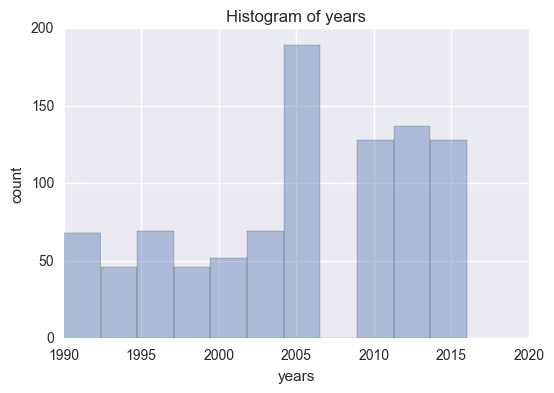

In [13]:
%matplotlib inline
sns.distplot(overall_data['year'], kde = False)
plt.title('Histogram of years')
plt.xlabel('years')
plt.ylabel('count')
plt.show()

### Histogram of Happy Planet Index values

C:\Users\Avi\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


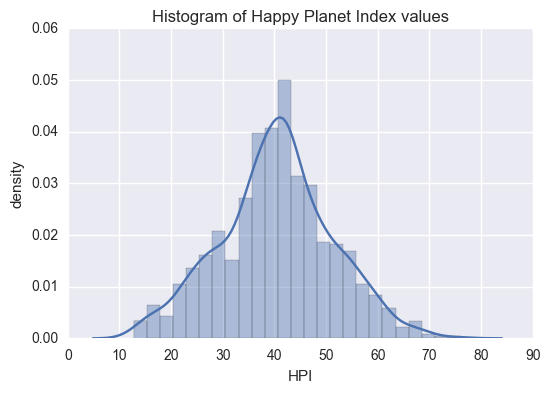

In [14]:
%matplotlib inline
sns.distplot(overall_data['Happy Planet Index'], bins = 25, kde = True)
plt.title('Histogram of Happy Planet Index values')
plt.xlabel('HPI')
plt.ylabel('density')
plt.show()

## Drop  columns with %(nulls)>85%

In [15]:
THRESH = 0.2
overall_data = overall_data.dropna(1, thresh=(overall_data.shape[0] * (1 - THRESH)))
overall_data.head(5)

,country,year,GDP PPP (constant 2011 international $),GDP PPP (current international $),GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GDP per capita PPP (constant 2011 international $),GDP per capita PPP (current international $),...,Population of the official entrance age to secondary general education female (number),Population of the official entrance age to secondary general education male (number),Population total,Theoretical duration of pre-primary education (years),Theoretical duration of primary education (years),Theoretical duration of secondary education (years),Unemployment female (% of female labor force),Unemployment male (% of male labor force),Unemployment total (% of total labor force),Happy Planet Index
0,Afghanistan,2012.0,5.646010e+10,5.750013e+10,1.935220e+10,2.053654e+10,651.001852,690.842629,1899.299559,1934.285634,...,385653.0,406854.0,29726803.0,4.0,6.0,6.0,12.1,7.9,8.5,36.8
1,Afghanistan,2016.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,434246.0,460532.0,NaN,4.0,6.0,6.0,NaN,NaN,NaN,20.2
2,Albania,2006.0,2.237198e+10,2.114751e+10,9.771760e+09,8.992642e+09,3265.365622,3005.012903,7475.899041,7066.725645,...,29913.0,31955.0,2992547.0,3.0,4.0,8.0,13.1,12.0,12.4,42.1
3,Albania,2009.0,2.632937e+10,2.734912e+10,1.150029e+10,1.204421e+10,3928.340828,4114.136545,8993.749193,9342.081246,...,27001.0,28893.0,2927519.0,3.0,5.0,7.0,16.4,12.0,13.8,47.9
4,Albania,2012.0,2.840013e+10,3.005072e+10,1.240477e+10,1.231978e+10,4277.143310,4247.839852,9792.315861,10361.433220,...,23095.0,24640.0,2900247.0,3.0,5.0,7.0,13.0,14.6,13.9,54.1


## Find Most Corrolated features

In [16]:
HPI_correlation = overall_data[overall_data.columns[1:-1]].apply\
(lambda x: x.corr(overall_data['Happy Planet Index'], method='spearman'))
HPI_correlation = HPI_correlation.abs().sort_values(ascending=False)
HPI_correlation = pd.DataFrame({'Feature':HPI_correlation.index,\
                                'Correlation to Happy Planet Index':HPI_correlation.values})
HPI_correlation.head(6)

,Correlation to Happy Planet Index,Feature
0,0.281749,Labor force female (% of total labor force)
1,0.278504,year
2,0.187799,GDP PPP (current international $)
3,0.187274,GNI PPP (current international $)
4,0.175914,GDP PPP (constant 2011 international $)
5,0.173915,Population ages 15-64 female


## Plot Corrolation matrix- taken 2 positive and 2 negative corrolated features

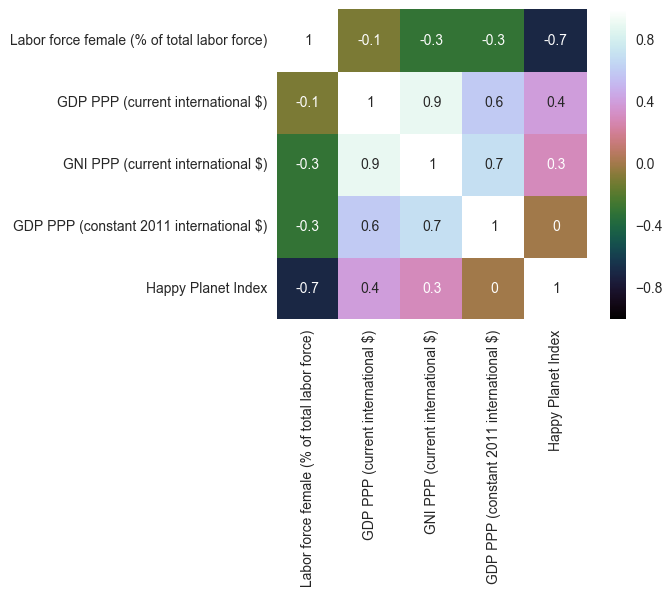

In [17]:
corr_features = HPI_correlation['Feature'].head(5).tolist() + ['Happy Planet Index']
corr_features = [x for x in corr_features if x != 'year']
overall_data_to_plot = overall_data[corr_features]
data_corr_mat= overall_data_to_plot.corr(method='spearman')
c = data_corr_mat.corr(method='spearman')
sns.heatmap(c, vmax=1, square=True, annot=True, cmap='cubehelix')

# Plotting Data on world map

In [18]:
# initialize list containing images' paths for concatination
countries_corrs = []

## Plotting the Happy Planet Index over the globe

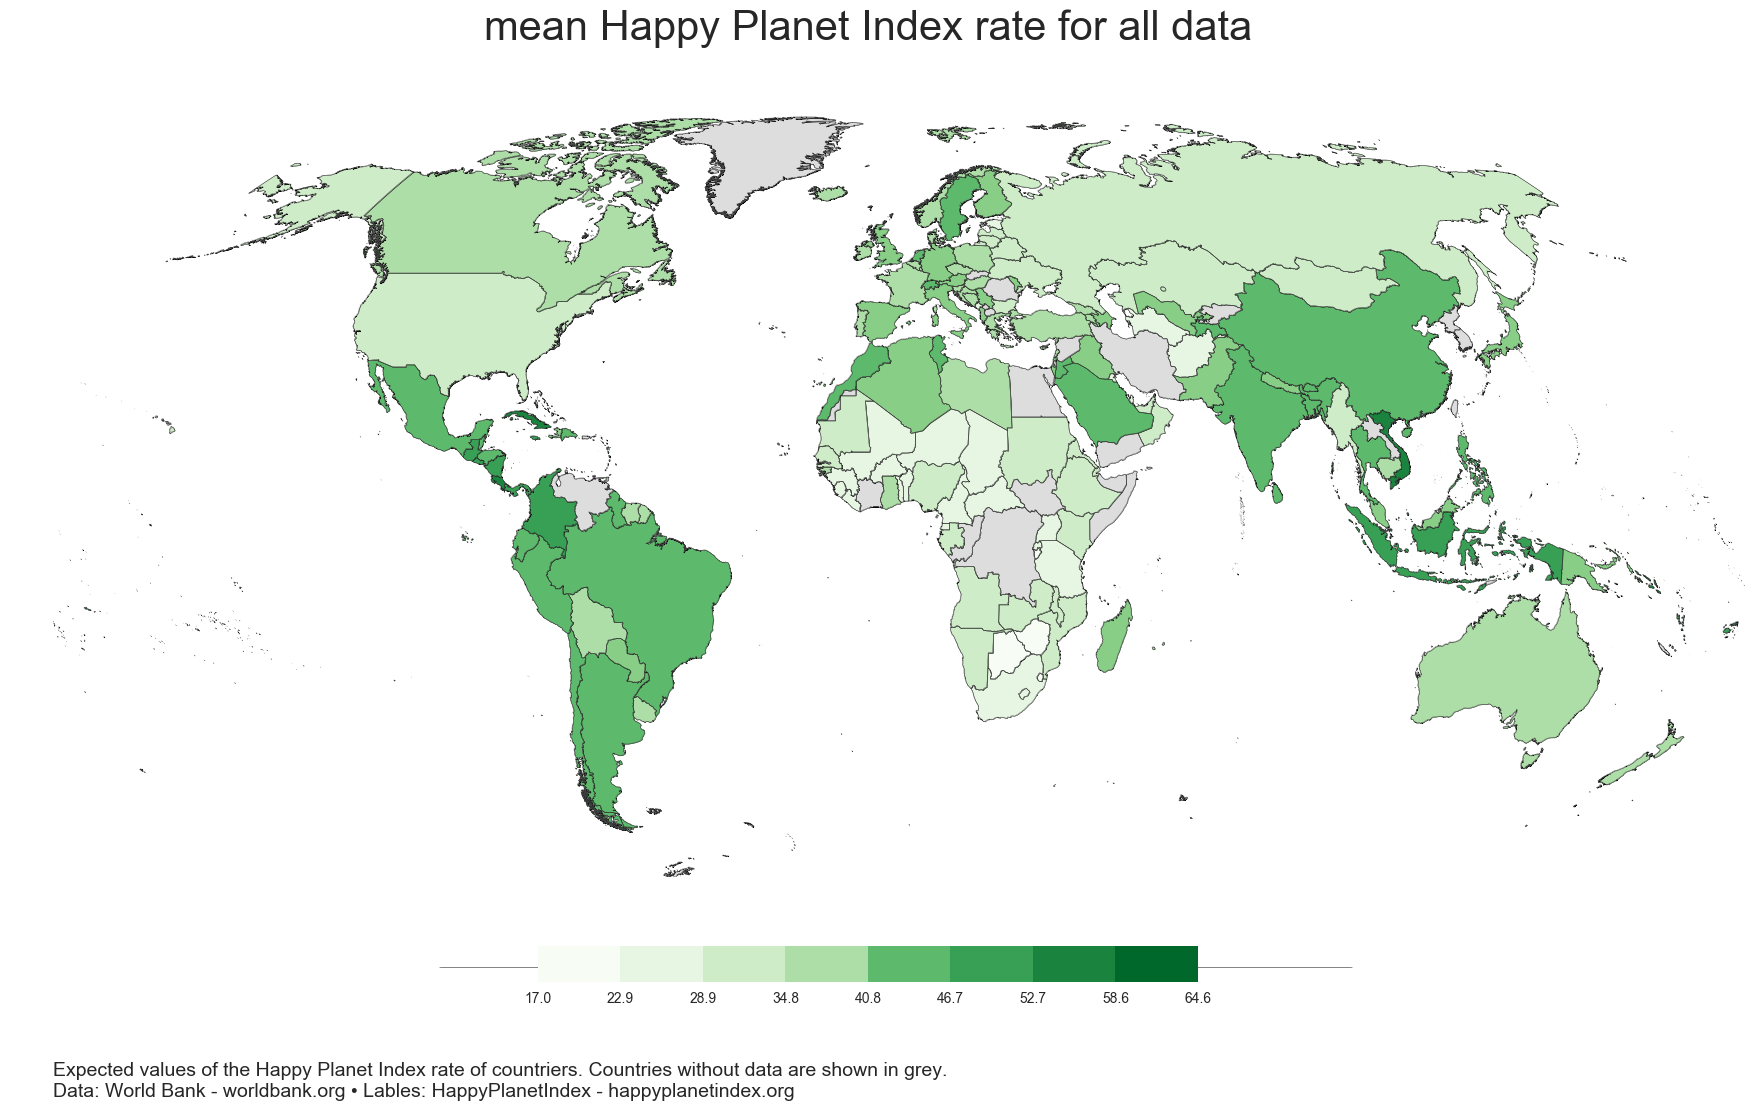

In [19]:
plotDataOnMap(overall_data, feature='Happy Planet Index', year='mean')

## Plotting the $1^{st}$ correlated feature over the globe

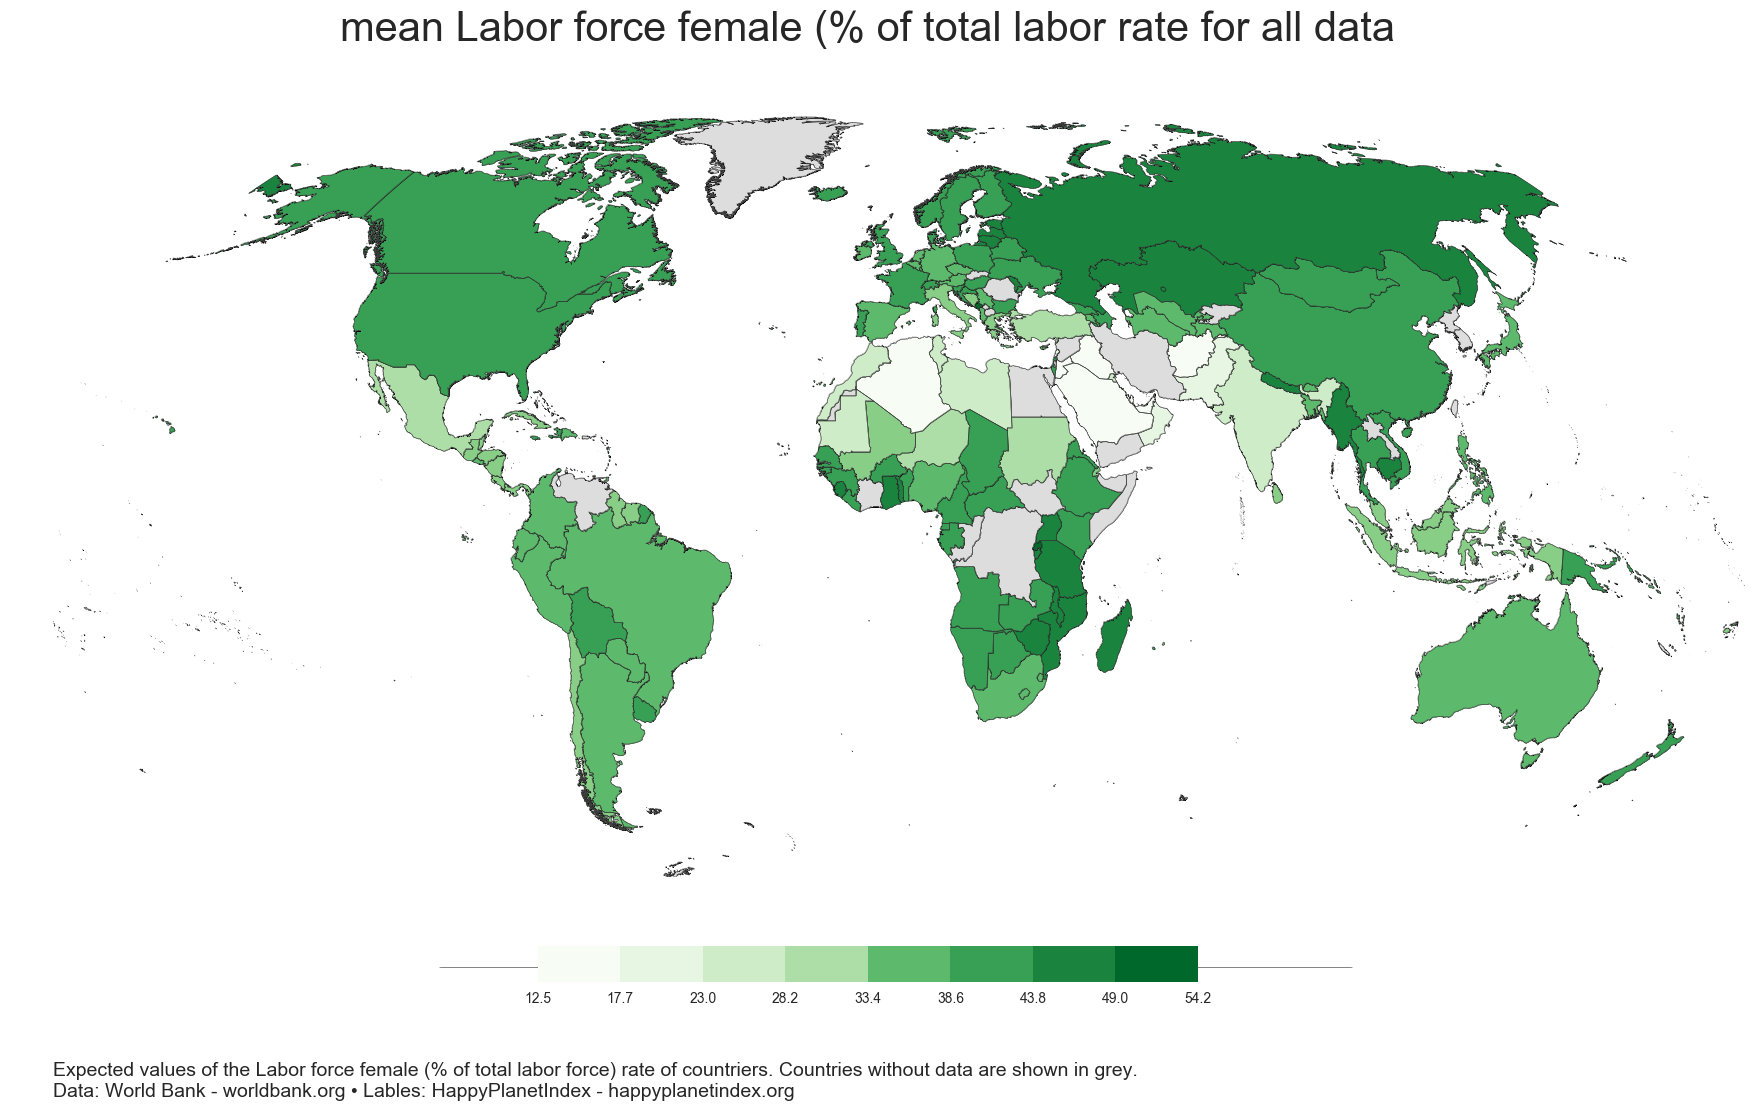

In [20]:
plotDataOnMap(overall_data, feature=corr_features[0], year='mean')

### Which Countries doesn't corrolate in the above feature and target

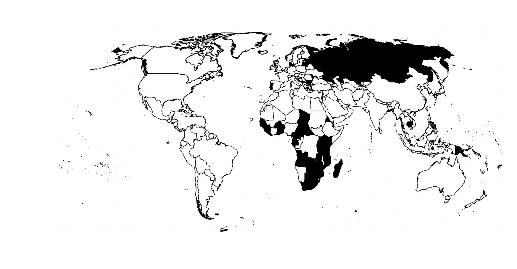

In [21]:
feature_image = globe_plots + 'Happy Planet Index_2012.png'
target_image = globe_plots + corr_features[0] +'_mean.png'
output_image = uncorrolated_plots + corr_features[0] + '.png'
countries_corrs.append(output_image)
plotUncorrolatedCountries(feature_image, target_image, output_image)

## Plotting the $2^{nd}$ correlated feature over the globe

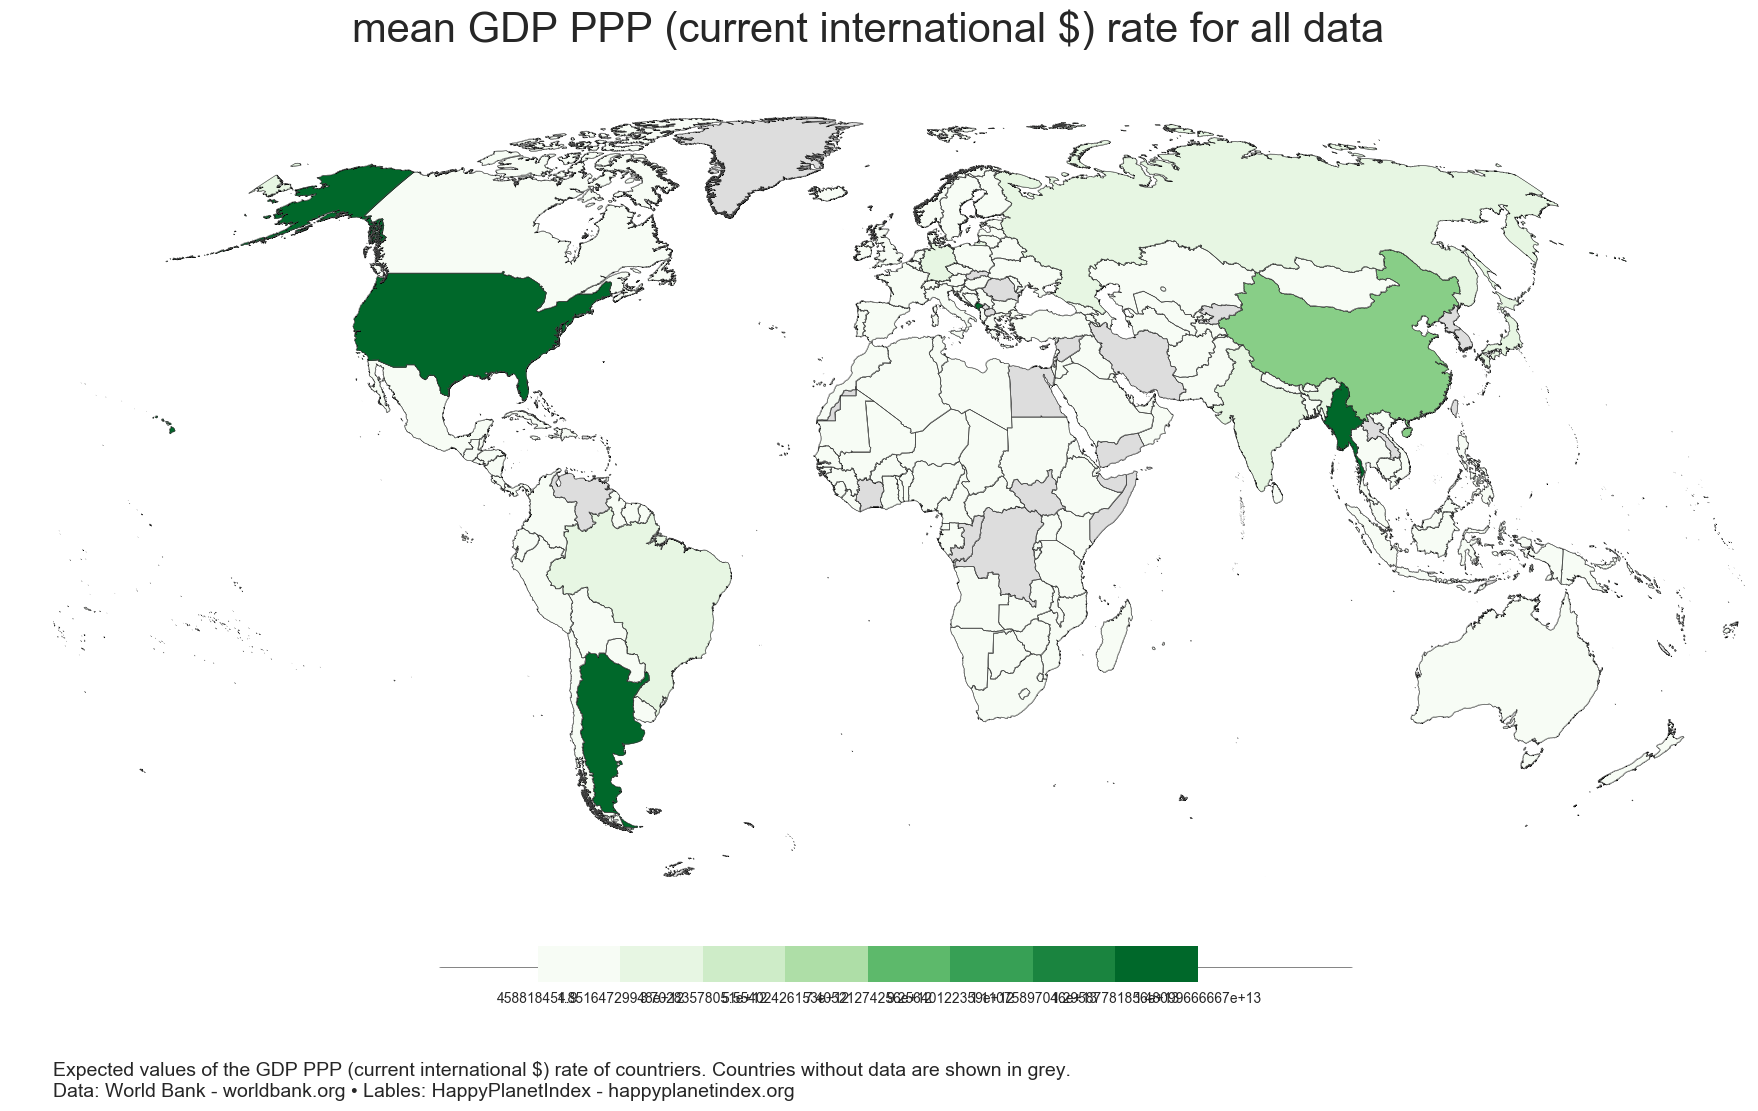

In [22]:
plotDataOnMap(overall_data, feature=corr_features[1], year='mean')

### Which Countries doesn't corrolate in the above feature and target

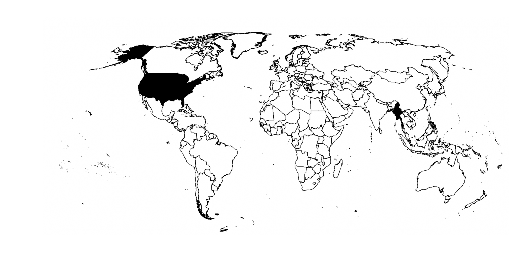

In [23]:
feature_image = globe_plots + 'Happy Planet Index_mean.png'
target_image = globe_plots + corr_features[1] +'_mean.png'
output_image = uncorrolated_plots + corr_features[1] +'.png'
countries_corrs.append(output_image)
plotUncorrolatedCountries(feature_image, target_image, output_image)

## Plotting the $3^{rd}$ correlated feature over the globe

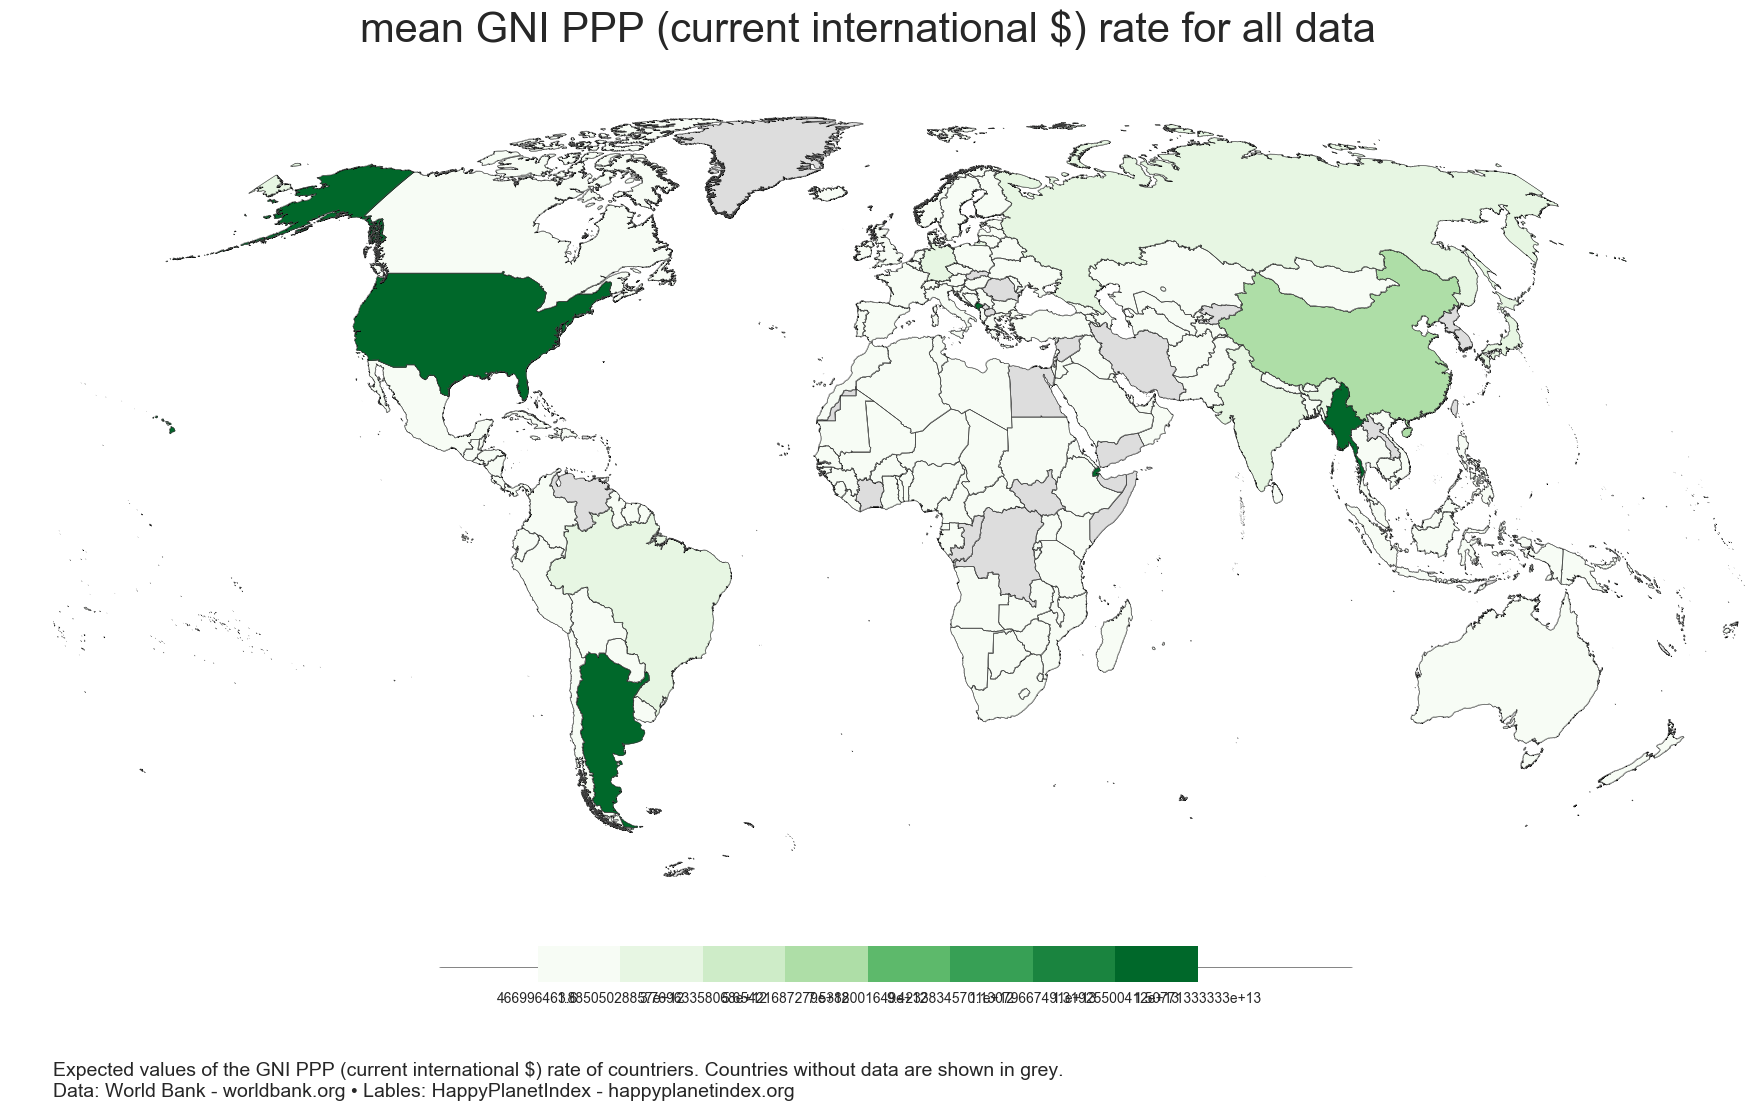

In [24]:
plotDataOnMap(overall_data, feature=corr_features[2], year='mean')

### Which Countries doesn't corrolate in the above feature and target

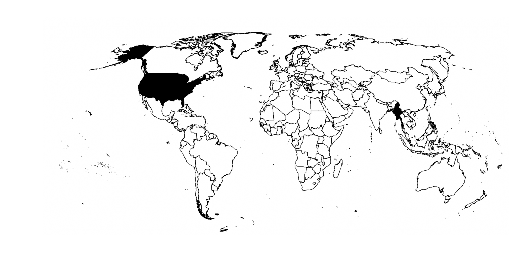

In [25]:
feature_image = globe_plots + 'Happy Planet Index_mean.png'
target_image = globe_plots + corr_features[2] + '_mean.png'
output_image = uncorrolated_plots + corr_features[2] + '.png'
countries_corrs.append(output_image)
plotUncorrolatedCountries(feature_image, target_image, output_image)

## Plotting the $4^{th}$ correlated feature over the globe

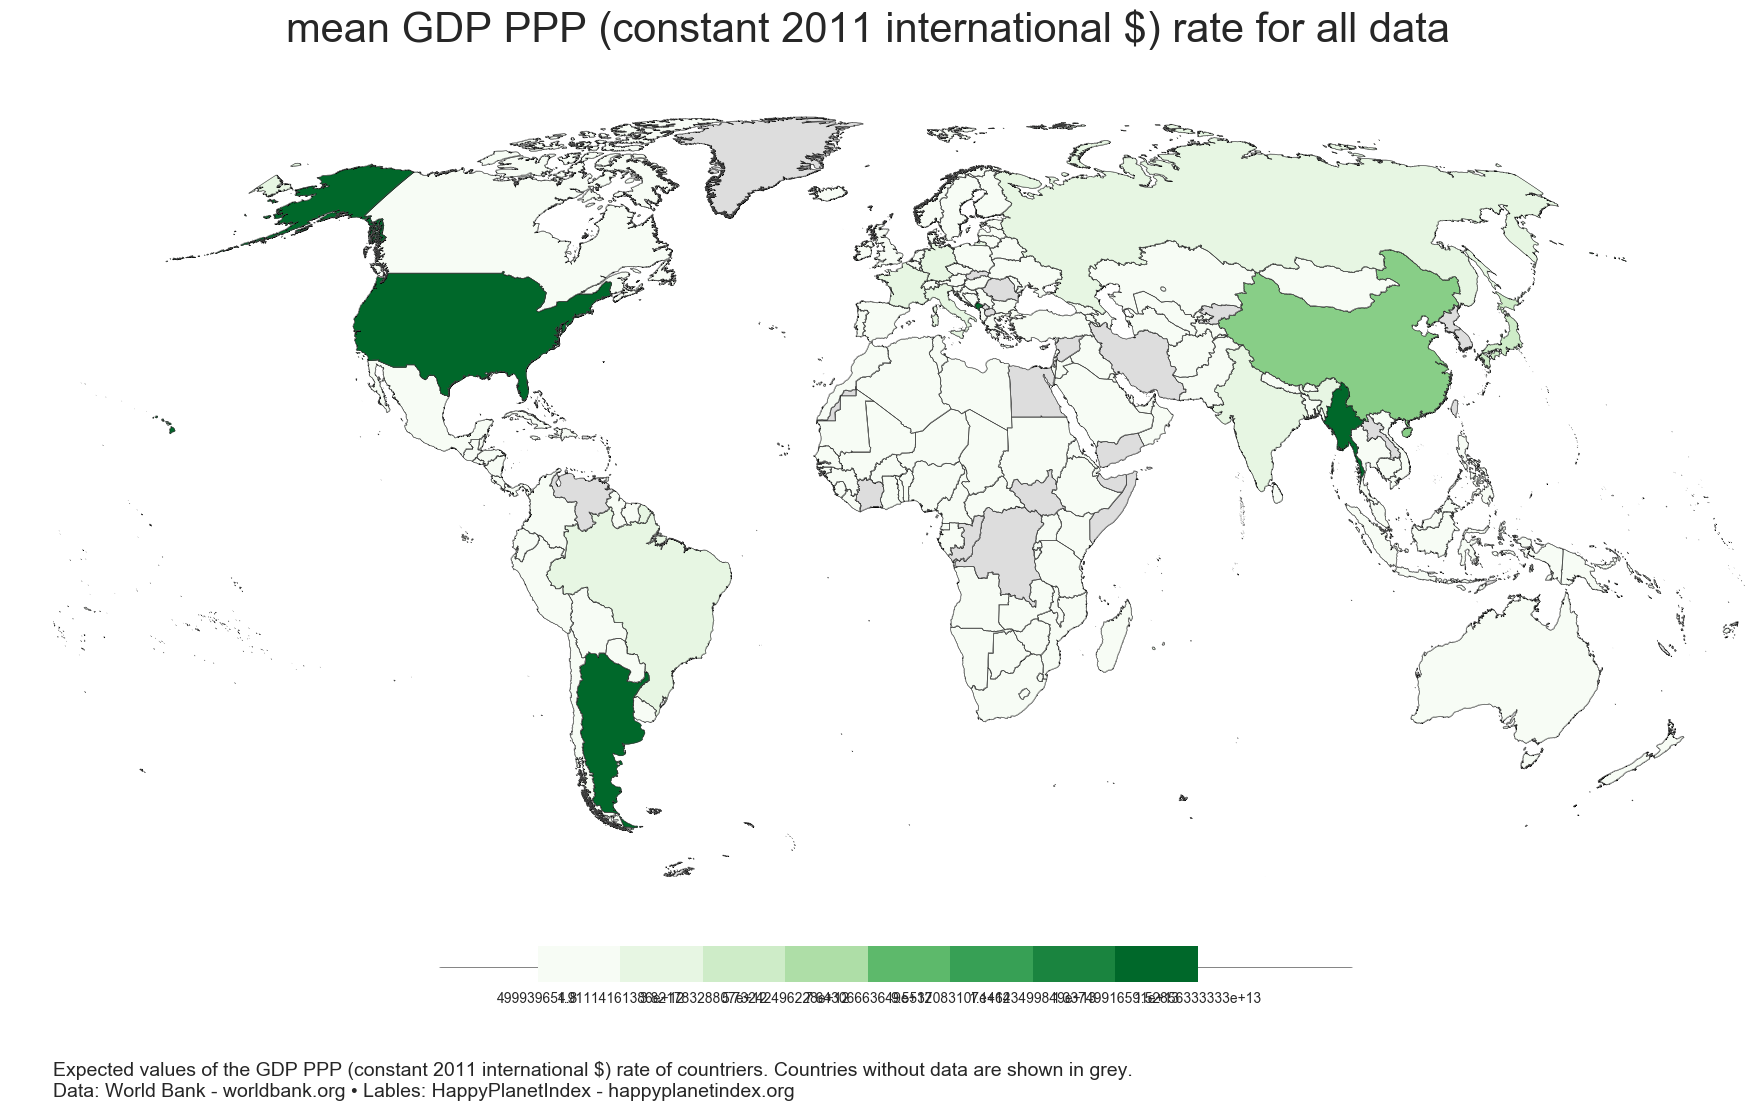

In [26]:
plotDataOnMap(overall_data, feature=corr_features[3], year='mean')

### Which Countries doesn't corrolate in the above feature and target

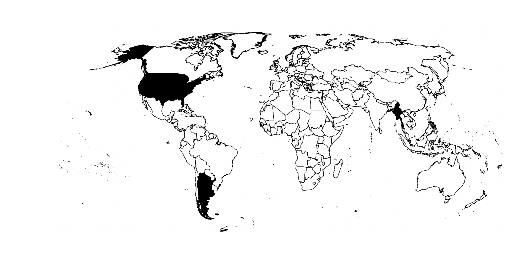

In [27]:
feature_image = globe_plots + 'Happy Planet Index_2012.png'
target_image = globe_plots + corr_features[3] + '_mean.png'
output_image = uncorrolated_plots + corr_features[3] + '.png'
countries_corrs.append(output_image)
plotUncorrolatedCountries(feature_image, target_image, output_image)

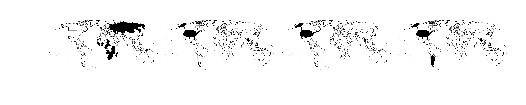

(<matplotlib.image.AxesImage at 0x1cb408a6c88>, None)

In [28]:
def concat_images(imga, imgb):
    """
    Combines two color image ndarrays side-by-side.
    """
    ha,wa = imga.shape[:2]
    hb,wb = imgb.shape[:2]
    max_height = np.max([ha, hb])
    total_width = wa+wb
    new_img = np.zeros(shape=(max_height, total_width), dtype=np.uint8)
    new_img[:ha,:wa]=imga
    new_img[:hb,wa:wa+wb]=imgb
    return new_img

def concat_n_images(image_path_list):
    """
    Combines N color images from a list of image paths.
    """
    output = None
    for i, img_path in enumerate(image_path_list):
        img = plt.imread(img_path)[:,:]
        if i==0:
            output = img
        else:
            output = concat_images(output, img)
    return output

out = concat_n_images(countries_corrs)
plt.axis('off')
plt.imshow(out, cmap = 'gray', interpolation = 'bicubic'),plt.show()

### Impute nulls with medians

In [29]:
overall_data = overall_data.fillna(overall_data.median())
overall_data.head(5)

,country,year,GDP PPP (constant 2011 international $),GDP PPP (current international $),GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GDP per capita PPP (constant 2011 international $),GDP per capita PPP (current international $),...,Population of the official entrance age to secondary general education female (number),Population of the official entrance age to secondary general education male (number),Population total,Theoretical duration of pre-primary education (years),Theoretical duration of primary education (years),Theoretical duration of secondary education (years),Unemployment female (% of female labor force),Unemployment male (% of male labor force),Unemployment total (% of total labor force),Happy Planet Index
0,Afghanistan,2012.0,5.646010e+10,5.750013e+10,1.935220e+10,2.053654e+10,651.001852,690.842629,1899.299559,1934.285634,...,385653.0,406854.0,29726803.0,4.0,6.0,6.0,12.1,7.9,8.5,36.8
1,Afghanistan,2016.0,2.358160e+11,1.818135e+11,2.012075e+11,1.414350e+11,19741.011565,14099.515080,24743.130720,18620.785825,...,434246.0,460532.0,10513883.0,4.0,6.0,6.0,7.5,6.5,6.9,20.2
2,Albania,2006.0,2.237198e+10,2.114751e+10,9.771760e+09,8.992642e+09,3265.365622,3005.012903,7475.899041,7066.725645,...,29913.0,31955.0,2992547.0,3.0,4.0,8.0,13.1,12.0,12.4,42.1
3,Albania,2009.0,2.632937e+10,2.734912e+10,1.150029e+10,1.204421e+10,3928.340828,4114.136545,8993.749193,9342.081246,...,27001.0,28893.0,2927519.0,3.0,5.0,7.0,16.4,12.0,13.8,47.9
4,Albania,2012.0,2.840013e+10,3.005072e+10,1.240477e+10,1.231978e+10,4277.143310,4247.839852,9792.315861,10361.433220,...,23095.0,24640.0,2900247.0,3.0,5.0,7.0,13.0,14.6,13.9,54.1


## One Hot Encoding Foreach Country

In [30]:
oh_overall_data = overall_data.drop('country', axis=1)
onehot_overall_col = pd.get_dummies(overall_data['country'], prefix='country')

#check for missing cols in onehot_overall_col
for col in onehot_overall_col.columns:
    if col not in onehot_overall_col.columns:
        onehot_overall_col[col] = 0
        
oh_overall_data = pd.concat([oh_overall_data, onehot_overall_col], axis=1)
overall_data = oh_overall_data
overall_data.head(5)

,year,GDP PPP (constant 2011 international $),GDP PPP (current international $),GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GDP per capita PPP (constant 2011 international $),GDP per capita PPP (current international $),GNI (current US$),...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe
0,2012.0,5.646010e+10,5.750013e+10,1.935220e+10,2.053654e+10,651.001852,690.842629,1899.299559,1934.285634,2.157185e+10,...,0,0,0,0,0,0,0,0,0,0
1,2016.0,2.358160e+11,1.818135e+11,2.012075e+11,1.414350e+11,19741.011565,14099.515080,24743.130720,18620.785825,1.407870e+11,...,0,0,0,0,0,0,0,0,0,0
2,2006.0,2.237198e+10,2.114751e+10,9.771760e+09,8.992642e+09,3265.365622,3005.012903,7475.899041,7066.725645,9.254605e+09,...,0,0,0,0,0,0,0,0,0,0
3,2009.0,2.632937e+10,2.734912e+10,1.150029e+10,1.204421e+10,3928.340828,4114.136545,8993.749193,9342.081246,1.185274e+10,...,0,0,0,0,0,0,0,0,0,0
4,2012.0,2.840013e+10,3.005072e+10,1.240477e+10,1.231978e+10,4277.143310,4247.839852,9792.315861,10361.433220,1.222802e+10,...,0,0,0,0,0,0,0,0,0,0


### Change all numeric values' datatypes to float

In [31]:
for variable in overall_data.columns:
    overall_data[variable] = overall_data[variable].astype(np.float)
overall_data.dtypes[:10]

year                                                  float64
GDP PPP (constant 2011 international $)               float64
GDP PPP (current international $)                     float64
GDP at market prices (constant 2005 US$)              float64
GDP at market prices (current US$)                    float64
GDP per capita (constant 2005 US$)                    float64
GDP per capita (current US$)                          float64
GDP per capita PPP (constant 2011 international $)    float64
GDP per capita PPP (current international $)          float64
GNI (current US$)                                     float64
dtype: object

## Split Data into training set and test set

In [134]:
# def splitToTrainAndTest(df):
#     msk = np.random.rand(len(df)) < 0.8
#     train = df[msk]
#     train.reset_index(drop=True, inplace=True)
#     test = df[~msk]
#     test.reset_index(drop=True, inplace=True)
#     train.to_csv(path_train)
#     test.to_csv(path_test)
# splitToTrainAndTest(overall_data)
#train_data = pd.read_csv(path_train, header=0, index_col=0, skiprows=0, encoding='iso-8859-1')
#test_data = pd.read_csv(path_test, header=0, index_col=0, skiprows=0, encoding='iso-8859-1')

## New splitting

In [41]:
train_data, test_data = train_test_split(overall_data, test_size = 0.2)
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
train_data.head(5)

,year,GDP PPP (constant 2011 international $),GDP PPP (current international $),GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GDP per capita PPP (constant 2011 international $),GDP per capita PPP (current international $),GNI (current US$),...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe
0,2016.0,2.358160e+11,1.818135e+11,2.012075e+11,1.414350e+11,19741.011565,14099.515080,24743.130720,18620.785825,1.407870e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1994.0,2.596960e+11,1.797730e+11,2.820310e+11,2.030450e+11,35537.711620,25584.917820,32723.284500,22652.459880,2.031110e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2006.0,1.187812e+10,1.090111e+10,4.363171e+09,2.931625e+09,440.799942,296.174576,1200.015593,1101.311518,2.593527e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012.0,1.529509e+10,1.557683e+10,6.541959e+09,6.942210e+09,370.948080,393.643423,867.275712,883.251377,6.806859e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1995.0,3.280410e+11,2.318410e+11,3.577420e+11,2.895680e+11,35291.418640,28565.946150,32361.390360,22871.159000,2.957620e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Partition to factors and class

In [42]:
train_class = train_data['Happy Planet Index']
train_factors = (train_data.drop('Happy Planet Index', axis=1))

test_class = test_data['Happy Planet Index']
test_factors =(test_data.drop('Happy Planet Index', axis=1))
train_factors.head(5)

,year,GDP PPP (constant 2011 international $),GDP PPP (current international $),GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GDP per capita PPP (constant 2011 international $),GDP per capita PPP (current international $),GNI (current US$),...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe
0,2016.0,2.358160e+11,1.818135e+11,2.012075e+11,1.414350e+11,19741.011565,14099.515080,24743.130720,18620.785825,1.407870e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1994.0,2.596960e+11,1.797730e+11,2.820310e+11,2.030450e+11,35537.711620,25584.917820,32723.284500,22652.459880,2.031110e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2006.0,1.187812e+10,1.090111e+10,4.363171e+09,2.931625e+09,440.799942,296.174576,1200.015593,1101.311518,2.593527e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012.0,1.529509e+10,1.557683e+10,6.541959e+09,6.942210e+09,370.948080,393.643423,867.275712,883.251377,6.806859e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1995.0,3.280410e+11,2.318410e+11,3.577420e+11,2.895680e+11,35291.418640,28565.946150,32361.390360,22871.159000,2.957620e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Binning The Years by Decades

In [43]:
#binning the years train
min_year = min(min(train_factors['year']), min(test_factors['year']))

def decade(year):
    return(math.floor((year-min_year) / 10))

for row in range(train_factors.shape[0]):
    val=train_factors.at[row, 'year']
    new_val=decade(val)
    train_factors.set_value(row, 'year', new_val)
    
#binning the years test

for row in range(test_factors.shape[0]):
    val=test_factors.at[row, 'year']
    new_val=decade(val)
    test_factors.set_value(row, 'year', new_val)
train_factors.head(5)

,year,GDP PPP (constant 2011 international $),GDP PPP (current international $),GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GDP per capita PPP (constant 2011 international $),GDP per capita PPP (current international $),GNI (current US$),...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe
0,2.0,2.358160e+11,1.818135e+11,2.012075e+11,1.414350e+11,19741.011565,14099.515080,24743.130720,18620.785825,1.407870e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,2.596960e+11,1.797730e+11,2.820310e+11,2.030450e+11,35537.711620,25584.917820,32723.284500,22652.459880,2.031110e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.187812e+10,1.090111e+10,4.363171e+09,2.931625e+09,440.799942,296.174576,1200.015593,1101.311518,2.593527e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.0,1.529509e+10,1.557683e+10,6.541959e+09,6.942210e+09,370.948080,393.643423,867.275712,883.251377,6.806859e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.280410e+11,2.318410e+11,3.577420e+11,2.895680e+11,35291.418640,28565.946150,32361.390360,22871.159000,2.957620e+11,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Centering and Scaling nomeric features, and removing features with: $STD\approx0$ 

In [44]:
train_factors = pd.DataFrame(sp.StandardScaler().fit_transform(train_factors),columns = train_factors.columns)
test_factors = pd.DataFrame(sp.StandardScaler().fit_transform(test_factors),columns = test_factors.columns)
train_factors.head(5)

,year,GDP PPP (constant 2011 international $),GDP PPP (current international $),GDP at market prices (constant 2005 US$),GDP at market prices (current US$),GDP per capita (constant 2005 US$),GDP per capita (current US$),GDP per capita PPP (constant 2011 international $),GDP per capita PPP (current international $),GNI (current US$),...,country_Ukraine,country_United Arab Emirates,country_United Kingdom,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Vietnam,country_Zambia,country_Zimbabwe
0,1.346142,-0.320605,-0.295543,-0.329397,-0.300819,-0.174705,-0.219879,0.028589,-0.044422,-0.297669,...,-0.082199,-0.063586,-0.157351,-0.051882,-0.051882,-0.051882,0.0,-0.082199,-0.073472,-0.073472
1,-1.405231,-0.303588,-0.297118,-0.264045,-0.246475,0.587945,0.488470,0.488856,0.233766,-0.243504,...,-0.082199,-0.063586,-0.157351,-0.051882,-0.051882,-0.051882,0.0,-0.082199,-0.073472,-0.073472
2,-0.029545,-0.480188,-0.427515,-0.488560,-0.422989,-1.106500,-1.071184,-1.329296,-1.253274,-0.417769,...,-0.082199,-0.063586,-0.157351,-0.051882,-0.051882,-0.051882,0.0,-0.082199,-0.073472,-0.073472
3,1.346142,-0.477753,-0.423905,-0.486798,-0.419452,-1.109873,-1.065173,-1.348487,-1.268320,-0.414107,...,-0.082199,-0.063586,-0.157351,-0.051882,-0.051882,-0.051882,0.0,-0.082199,-0.073472,-0.073472
4,-1.405231,-0.254883,-0.256913,-0.202827,-0.170155,0.576054,0.672322,0.467984,0.248856,-0.162984,...,-0.082199,-0.063586,-0.157351,-0.051882,-0.051882,-0.051882,0.0,-0.082199,-0.073472,-0.073472


## Apply PCA for data visualizaion

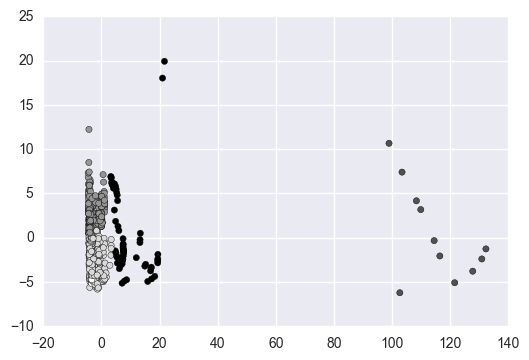

In [45]:
# Import the kmeans clustering model.
def twoDimPCAandClustering(train_factors):
    # Initialize the model with 2 parameters -- number of clusters and random state.
    kmeans_model = KMeans(n_clusters=5, random_state=1)
    # Get only the numeric columns from games.
    # Fit the model using the good columns.
    kmeans_model.fit(train_factors)
    # Get the cluster assignments.
    labels = kmeans_model.labels_
    #Import the PCA model.

    # Create a PCA model.
    pca_2 = PCA(2)
    # Fit the PCA model on the numeric columns from earlier.
    plot_columns = pca_2.fit_transform(train_factors)
    # Make a scatter plot of each game, shaded according to cluster assignment.
    plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=labels)
    # Show the plot.
    plt.show()
    return plot_columns, labels
plot_columns, labels = twoDimPCAandClustering(train_factors)

## Feature selection with E.Net model

In [47]:
# run elastic model for feature selection 
enet = ElasticNetCV(max_iter=60000, cv=20, n_jobs=-1)
enet.fit(train_factors, train_class)

sfm = fs.SelectFromModel(enet, prefit=True)
chosen_features_and_coefs = [(train_factors.columns[i],enet.coef_[i]) for i in sfm.get_support(True)]

def comp(tuple):
    return abs(tuple[1])

chosen_features_and_coefs.sort(key=comp, reverse=True)
headers = [['correlated feature', 'linear correlation rate to target']]
data = headers + [[x[0], x[1]]\
                  for x in chosen_features_and_coefs]
headers = data.pop(0) # gives the headers as list and leaves data
table = pd.DataFrame(data, columns=headers)
print("Enet Strong factors are: ")
table.head(10)

Enet Strong factors are: 


,correlated feature,linear correlation rate to target
0,Population ages 0-14 (% of total),5.607263
1,GDP per capita PPP (constant 2011 internationa...,-5.416621
2,Internet users (per 100 people),4.292911
3,year,-3.508965
4,Population ages 15-64 (% of total),2.957084
5,Labor force female (% of total labor force),-2.093738
6,country_Sweden,2.055428
7,country_Switzerland,1.766582
8,country_South Africa,-1.493878
9,country_Vietnam,1.479582


## Compute MSE on training set for Enet prediction

In [48]:
train_predictions = enet.predict(train_factors)

# Compute the error.test_mse = mean_squared_error(y_test, rf.predict(test_factors))
train_rmse = np.sqrt(mean_squared_error(train_class, train_predictions))
                    
print("train RMSE, %.4f" % (train_rmse))

train RMSE, 4.3731


## Countries corrolated to target plot

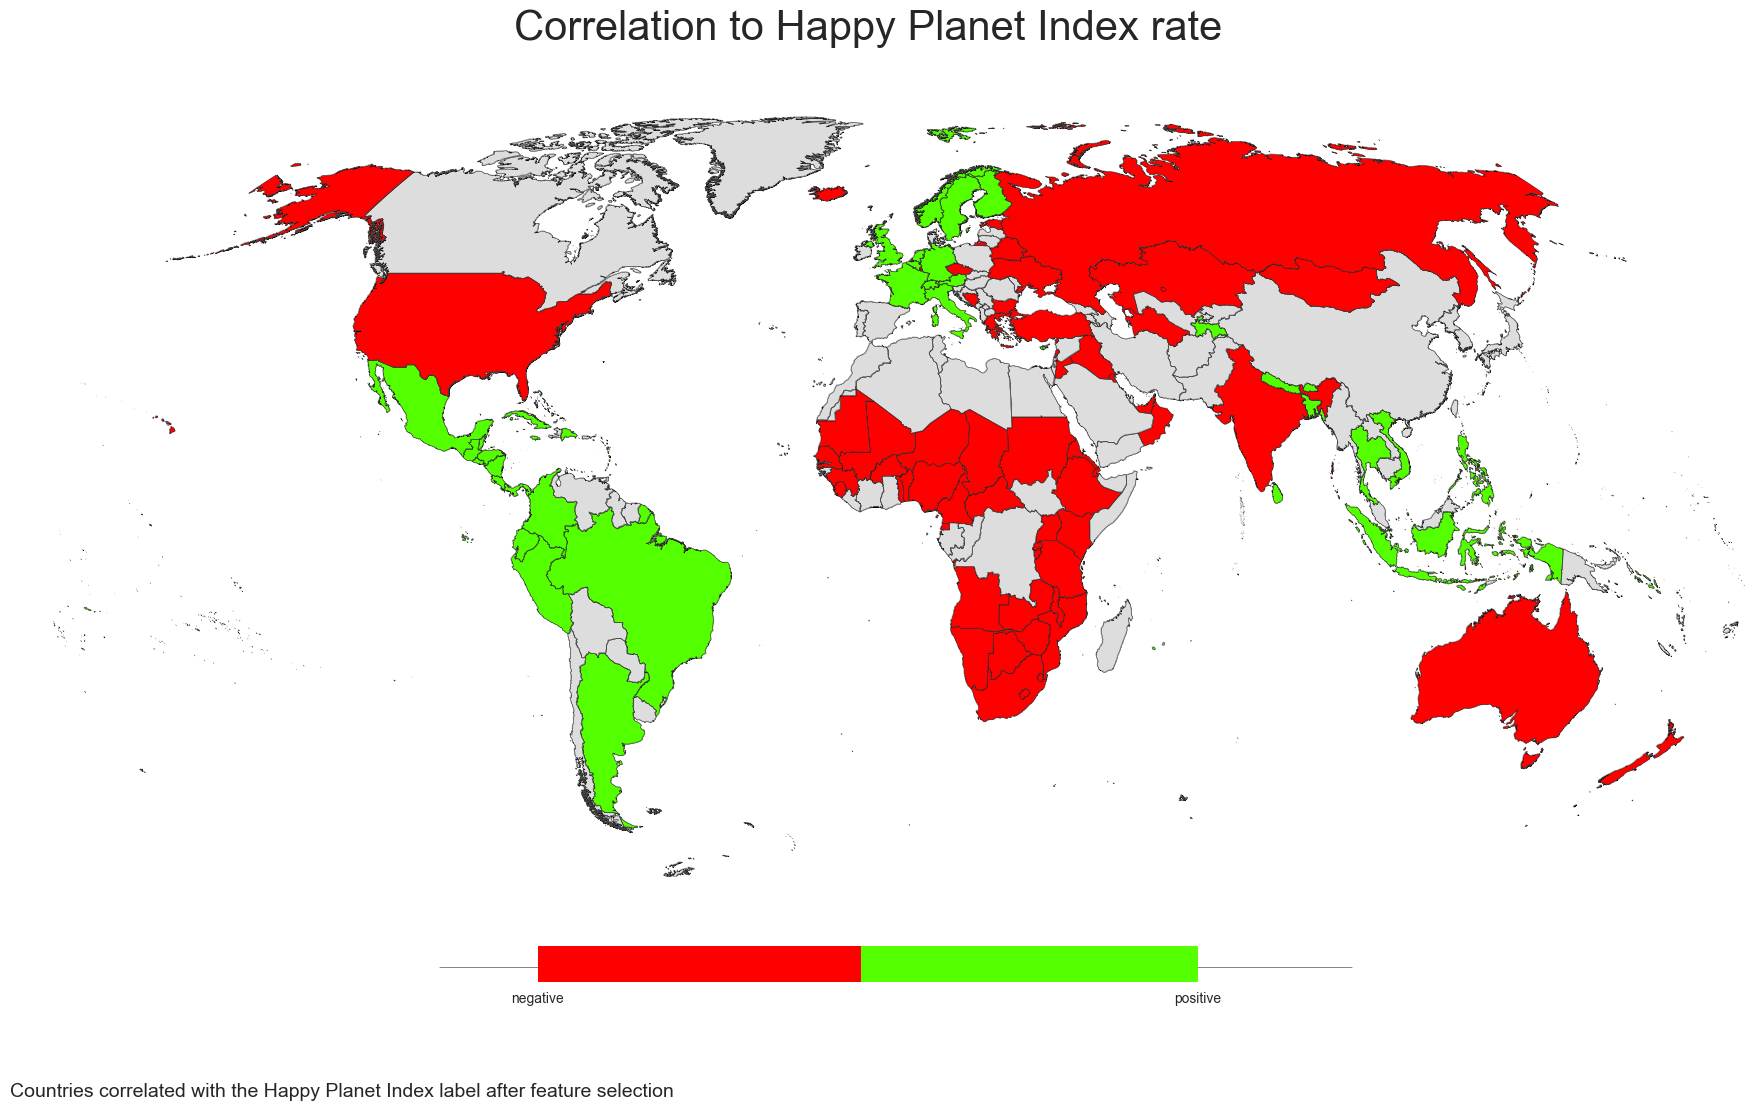

In [49]:
headers = [['country', 'Correlation to Happy Planet Index']]
data = headers + [[x[0].split('country_')[1], np.sign(x[1])]\
                  for x in chosen_features_and_coefs if x[0].startswith('country_')]
headers = data.pop(0) # gives the headers as list and leaves data
df = pd.DataFrame(data, columns=headers)
plotDataOnMap(df, year='mean', feature="Correlation to Happy Planet Index", binary=True,\
              descripton='Countries correlated with the Happy Planet Index label after feature selection')

### Take remained features

In [50]:
chosen_features = [x[0] for x in chosen_features_and_coefs]
train_factors = train_factors[chosen_features]
test_factors = test_factors[chosen_features]
train_factors.head(5)

,Population ages 0-14 (% of total),GDP per capita PPP (constant 2011 international $),Internet users (per 100 people),year,Population ages 15-64 (% of total),Labor force female (% of total labor force),country_Sweden,country_Switzerland,country_South Africa,country_Vietnam,...,country_Nepal,country_Equatorial Guinea,country_Belize,country_Cyprus,Population of the official age for lower secondary education female (number),country_Bosnia and Herzegovina,country_Bulgaria,country_Bhutan,country_United Kingdom,country_Greece
0,-0.449657,0.028589,-0.348535,1.346142,0.306601,0.259641,-0.161774,-0.148148,-0.090106,-0.082199,...,-0.073472,-0.036662,-0.073472,-0.073472,-0.231621,-0.063586,-0.090106,-0.051882,-0.157351,-0.133265
1,-0.702631,0.488856,-0.891261,-1.405231,0.475112,0.108756,-0.161774,-0.148148,-0.090106,-0.082199,...,-0.073472,-0.036662,-0.073472,-0.073472,-0.252671,-0.063586,-0.090106,-0.051882,-0.157351,-0.133265
2,2.112718,-1.329296,-0.921761,-0.029545,-2.247725,0.478200,-0.161774,-0.148148,-0.090106,-0.082199,...,-0.073472,-0.036662,-0.073472,-0.073472,-0.186142,-0.063586,-0.090106,-0.051882,-0.157351,-0.133265
3,2.785389,-1.348487,-0.890685,1.346142,-3.312716,-1.695311,-0.161774,-0.148148,-0.090106,-0.082199,...,-0.073472,-0.036662,-0.073472,-0.073472,-0.102811,-0.063586,-0.090106,-0.051882,-0.157351,-0.133265
4,-0.663460,0.467984,-0.907471,-1.405231,0.242862,-0.127396,-0.161774,-0.148148,-0.090106,-0.082199,...,-0.073472,-0.036662,-0.073472,-0.073472,-0.268209,-0.063586,-0.090106,-0.051882,-0.157351,-0.133265


### Apply PCA after feature selection

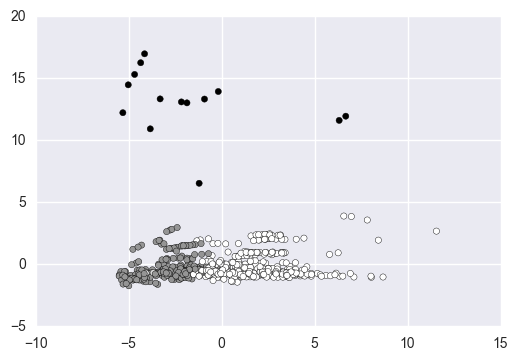

In [51]:
plot_columns, labels = twoDimPCAandClustering(train_factors)

## Features extraction

In [52]:
poly = sp.PolynomialFeatures(2, include_bias=False)
transf_train = poly.fit_transform(train_factors)
transf_test = poly.fit_transform(test_factors)
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(train_factors.columns,p) for p in poly.powers_]]
train_factors_after_extracion = (pd.DataFrame(transf_train, columns = target_feature_names))
test_factors_after_extracion = (pd.DataFrame(transf_test, columns = target_feature_names))
train_factors_after_extracion.head(5)

,Population ages 0-14 (% of total)^1,GDP per capita PPP (constant 2011 international $)^1,Internet users (per 100 people)^1,year^1,Population ages 15-64 (% of total)^1,Labor force female (% of total labor force)^1,country_Sweden^1,country_Switzerland^1,country_South Africa^1,country_Vietnam^1,...,country_Bulgaria^2,country_Bulgaria^1xcountry_Bhutan^1,country_Bulgaria^1xcountry_United Kingdom^1,country_Bulgaria^1xcountry_Greece^1,country_Bhutan^2,country_Bhutan^1xcountry_United Kingdom^1,country_Bhutan^1xcountry_Greece^1,country_United Kingdom^2,country_United Kingdom^1xcountry_Greece^1,country_Greece^2
0,-0.449657,0.028589,-0.348535,1.346142,0.306601,0.259641,-0.161774,-0.148148,-0.090106,-0.082199,...,0.008119,0.004675,0.014178,0.012008,0.002692,0.008164,0.006914,0.024759,0.020969,0.01776
1,-0.702631,0.488856,-0.891261,-1.405231,0.475112,0.108756,-0.161774,-0.148148,-0.090106,-0.082199,...,0.008119,0.004675,0.014178,0.012008,0.002692,0.008164,0.006914,0.024759,0.020969,0.01776
2,2.112718,-1.329296,-0.921761,-0.029545,-2.247725,0.478200,-0.161774,-0.148148,-0.090106,-0.082199,...,0.008119,0.004675,0.014178,0.012008,0.002692,0.008164,0.006914,0.024759,0.020969,0.01776
3,2.785389,-1.348487,-0.890685,1.346142,-3.312716,-1.695311,-0.161774,-0.148148,-0.090106,-0.082199,...,0.008119,0.004675,0.014178,0.012008,0.002692,0.008164,0.006914,0.024759,0.020969,0.01776
4,-0.663460,0.467984,-0.907471,-1.405231,0.242862,-0.127396,-0.161774,-0.148148,-0.090106,-0.082199,...,0.008119,0.004675,0.014178,0.012008,0.002692,0.008164,0.006914,0.024759,0.020969,0.01776


In [53]:
poly = sp.PolynomialFeatures(2, include_bias=False)
transf_train = poly.fit_transform(train_factors)
target_feature_names = ['x'.join(['{}^{}'.format(pair[0],pair[1]) for pair in tuple if pair[1]!=0]) for tuple in [zip(train_factors.columns,p) for p in poly.powers_]]
train_factors_after_extracion = (pd.DataFrame(transf_train, columns = target_feature_names))

HPI_correlation = train_factors_after_extracion[train_factors_after_extracion.columns[:]].apply\
(lambda x: x.corr(train_data['Happy Planet Index'], method='spearman'))
HPI_correlation = HPI_correlation.abs().sort_values(ascending=False)
HPI_correlation = pd.DataFrame({'Feature':HPI_correlation.index,\
                                'Correlation to Happy Planet Index':HPI_correlation.values})
HPI_correlation.head(6)

,Correlation to Happy Planet Index,Feature
0,0.391043,Labor force female (% of total labor force)^1x...
1,0.389768,Labor force female (% of total labor force)^1x...
2,0.381672,Labor force female (% of total labor force)^1x...
3,0.352732,Labor force female (% of total labor force)^1x...
4,0.340030,GDP per capita PPP (constant 2011 internationa...
5,0.314875,Labor force female (% of total labor force)^1x...


## Polynomial Feature selection - not in use

#### Please be patient, it takes a while

In [ ]:
# run elastic model for feature selection 
enet = ElasticNetCV(max_iter=60000, cv=10, n_jobs=-1)
enet.fit(train_factors_after_extracion, train_class)

sfm = fs.SelectFromModel(enet, prefit=True)
chosen_features_and_coefs = [(train_factors_after_extracion.columns[i],enet.coef_[i]) for i in sfm.get_support(True)]

def comp(tuple):
    return abs(tuple[1])

chosen_features_and_coefs.sort(key=comp, reverse=True)
headers = [['correlated feature', 'linear correlation rate to target']]
data = headers + [[x[0], x[1]]\
                  for x in chosen_features_and_coefs if x[1] != 0.0 ]
headers = data.pop(0) # gives the headers as list and leaves data
table = pd.DataFrame(data, columns=headers)
print("Enet Strong factors are: ")
table.head(10)

## Take the rellevant features - not in use

In [ ]:
train_factors = train_factors[chosen_pol_features_list]
test_factors = test_factors[chosen_pol_features_list]
train_factors.head(5)

# Kernel Ridge model

In [ ]:
from sklearn.kernel_ridge import KernelRidge

#tuned_parameters = {'alpha': [1, 0.1, 0.15, 0.155, 0.1555], 'degree': [1, 2, 3, 4, 5], 'gamma': [1,0.1,0.01,0.001, 0.0001, None], 'kernel': ['polynomial']}
#model = KernelRidge(alpha=0.007, degree=2, kernel='polynomial',gamma=0.0022)
#model = KernelRidge(alpha=0.00007, degree=2, kernel='polynomial',gamma=0.000022)

param_grid = {'alpha': [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12],\
              'gamma': [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]}
cross_v = train_factors.shape[0]
model = GridSearchCV(KernelRidge(degree=2, kernel='polynomial'), cv=10, param_grid=param_grid)


model.fit(train_factors, train_class)
test_predictions = model.predict(test_factors)
train_predictions = model.predict(train_factors)

In [61]:
# Initialize the model with some parameters.
#tuned_parameters = {'n_estimators': [300, 500, 700, 1000], 'max_features':[50,100,500,1000,5000,10000], 'max_depth': [None, 1, 2, 3], 'min_samples_split': [1, 2, 3]}
#model = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, 
#                   n_jobs=-1, verbose=1)
#model = RandomForestRegressor(n_estimators=500, max_features=136, min_samples_split=3)
model = RandomForestRegressor(n_estimators=1000, max_features=len(chosen_features), min_samples_leaf=1, max_depth=None)
# Fit the model to the data.
model.fit(train_factors, train_class)
# Make predictions.
test_predictions = model.predict(test_factors)
train_predictions = model.predict(train_factors)

In [ ]:
# Compute the error.test_mse = mean_squared_error(y_test, rf.predict(test_factors))
train_mse = np.sqrt(mean_squared_error(train_class, train_predictions))
test_mse = np.sqrt(mean_squared_error(test_class, test_predictions))

print("train RMSE, %.4f, test RMSE: %.4f" % (train_mse, test_mse))

C:\Users\Avi\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Avi\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


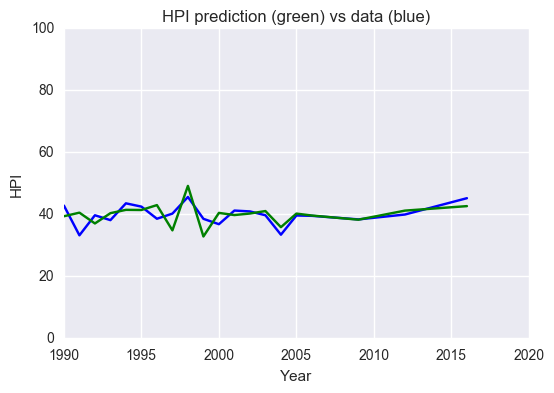

In [57]:
data_to_plot = train_data[['year']]
data_to_plot['prediction'] = pd.Series(test_predictions)
data_to_plot['class'] = pd.Series(test_class)

data_to_plot1 = data_to_plot.groupby('year').mean()
data_to_plot1.reset_index(inplace=True)

lines = plt.plot(data_to_plot1['year'].tolist(),data_to_plot1['class'].tolist(), color='b')
lines = plt.plot(data_to_plot1['year'].tolist(),data_to_plot1['prediction'].tolist(), color='g')

plt.ylabel('HPI')
plt.xlabel('Year')
plt.title('HPI prediction (green) vs data (blue)')
plt.ylim(0,100)
plt.show()

C:\Users\Avi\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


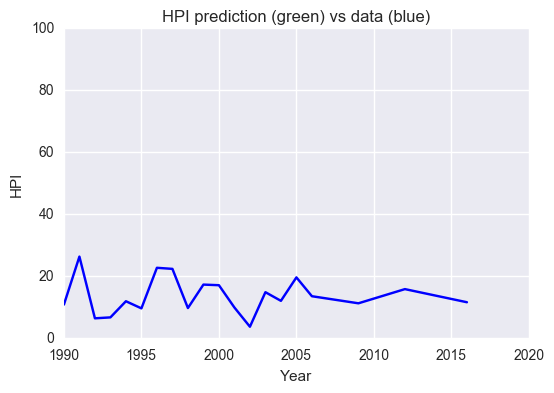

The average percantage error: 13.50056893088049 %


In [58]:
def errPercentage(value, predites):
    return (abs(value-predites)/value)*100

data_to_plot['errPercentage'] = data_to_plot.apply(lambda row: errPercentage(row['class'], row['prediction']), axis=1)

data_to_plot2 = data_to_plot.groupby('year').mean()
data_to_plot2.reset_index(inplace=True)

lines = plt.plot(data_to_plot2['year'].tolist(),data_to_plot2['errPercentage'].tolist(), color='b')

plt.ylabel('HPI')
plt.xlabel('Year')
plt.title('HPI prediction (green) vs data (blue)')
plt.ylim(0,100)
plt.show()

print('The average percantage error:', data_to_plot['errPercentage'].mean(), '%')